# Demo 3: 特征贡献（PSSM 维度对比）

参考 AcrPred：从 full experiment 结果中筛选 Ablation_RPSSM_110/310/710/1110，绘制 AUC（或 AUPRC）mean ± std 柱状图。

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

PROJECT_ROOT = '/home/nemophila/projects/protein_bert'
WORK_ROOT = os.path.join(PROJECT_ROOT, 'pssm_work')
SUMMARY_PATH = os.path.join(WORK_ROOT, 'features', 'full_plan_exp_summary_with_stage5_noleak.csv')

if not os.path.exists(SUMMARY_PATH):
    raise FileNotFoundError(f'Run full experiment first to generate {SUMMARY_PATH}')

df = pd.read_csv(SUMMARY_PATH, index_col=0, header=[0, 1])
df.index = df.index.astype(str).str.strip()
print('Available experiments:', list(df.index))

Available experiments: ['Fusion_PSSM1110_B', 'Fusion_PSSM1110', 'Fusion_PSSM1110_ANOVA_IFS_noLeak', 'Fusion_PSSM710_ANOVA_IFS_noLeak', 'Fusion_PSSM1110_A', 'Fusion_PSSM710_B', 'Fusion_PSSM710', 'Fusion_PSSM710_A', 'Fusion_PSSM110', 'Fusion_PSSM310', 'Baseline_head_two_layer', 'Baseline_head_two_layer_lowdrop', 'Baseline_head_two_layer_lowlr', 'Ablation_RPSSM_1110', 'Ablation_RPSSM_1110_FS', 'Baseline_head_default', 'Ablation_RPSSM_710_FS', 'Ablation_RPSSM_710', 'Ablation_RPSSM_310', 'Ablation_RPSSM_310_FS', 'Ablation_RPSSM_110']


In [2]:
ablation_exps = ['Ablation_RPSSM_110', 'Ablation_RPSSM_310', 'Ablation_RPSSM_710', 'Ablation_RPSSM_1110']
sub = df.loc[[e for e in ablation_exps if e in df.index]]
dims = [110, 310, 710, 1110]
order = [f'Ablation_RPSSM_{d}' for d in dims]
sub = sub.reindex([e for e in order if e in sub.index])
dims_used = [int(e.split('_')[-1]) for e in sub.index]

auc_mean = sub[('AUC', 'mean')].values
auc_std = sub[('AUC', 'std')].values
auprc_mean = sub[('AUPRC', 'mean')].values
auprc_std = sub[('AUPRC', 'std')].values

## PSSM 维度对比：AUC 与 AUPRC

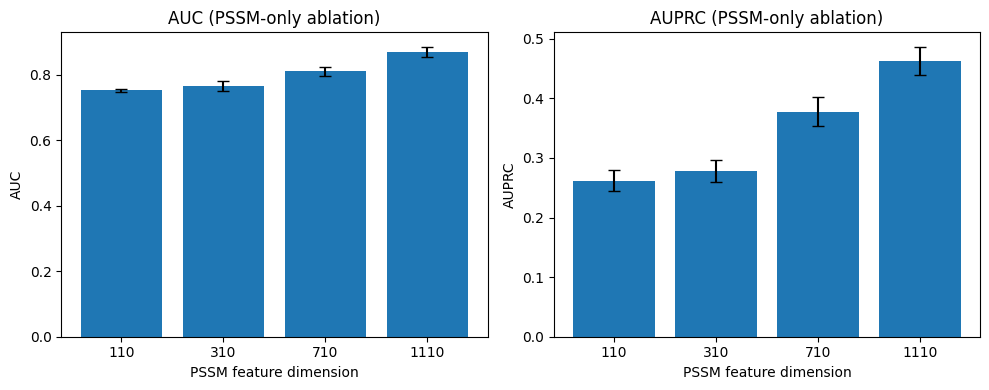

                          AUC               AUPRC          
                         mean       std      mean       std
Exp                                                        
Ablation_RPSSM_110   0.751982  0.005082  0.262020  0.017509
Ablation_RPSSM_310   0.765089  0.014609  0.278169  0.018209
Ablation_RPSSM_710   0.809734  0.013133  0.377616  0.024460
Ablation_RPSSM_1110  0.869704  0.015105  0.462998  0.023326


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
x = np.arange(len(dims_used))

axes[0].bar(x, auc_mean, yerr=auc_std, capsize=4)
axes[0].set_xticks(x)
axes[0].set_xticklabels(dims_used)
axes[0].set_xlabel('PSSM feature dimension')
axes[0].set_ylabel('AUC')
axes[0].set_title('AUC (PSSM-only ablation)')

axes[1].bar(x, auprc_mean, yerr=auprc_std, capsize=4)
axes[1].set_xticks(x)
axes[1].set_xticklabels(dims_used)
axes[1].set_xlabel('PSSM feature dimension')
axes[1].set_ylabel('AUPRC')
axes[1].set_title('AUPRC (PSSM-only ablation)')

plt.tight_layout()
plt.show()
print(sub[[('AUC','mean'),('AUC','std'),('AUPRC','mean'),('AUPRC','std')]].to_string())

## PSSM 1110 维特征 t-SNE（仅 PSSM，不融合 ProteinBERT）

单独使用 PSSM 1110 维特征（与 Ablation PSSM-only 一致），按训练集 / 验证集 / 测试集分别做 t-SNE，各画一张图，按 Acr / Non-Acr 着色。

In [6]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from proteinbert import load_anticrispr_with_ids, load_feature_cache, attach_pssm_features

BENCHMARKS_DIR = os.path.join(PROJECT_ROOT, 'anticrispr_benchmarks')
FEAT_DIR = os.path.join(WORK_ROOT, 'features')
PSSM_DIM = '1110'
VALID_SEED = 42
parquet_path = os.path.join(FEAT_DIR, f'pssm_features_{PSSM_DIM}.parquet')
csv_path = os.path.join(FEAT_DIR, f'pssm_features_{PSSM_DIM}.csv')
cache_path = parquet_path if os.path.exists(parquet_path) else csv_path
if not os.path.exists(cache_path):
    raise FileNotFoundError(f'PSSM cache not found: {cache_path}')

train_df, test_df = load_anticrispr_with_ids(BENCHMARKS_DIR, benchmark_name='anticrispr_binary')
sub_train, sub_valid = train_test_split(
    train_df, test_size=0.1, stratify=train_df['label'], random_state=VALID_SEED
)
feat_df, feat_cols = load_feature_cache(cache_path)
train_with_pssm = attach_pssm_features(sub_train, feat_df, feat_cols)
valid_with_pssm = attach_pssm_features(sub_valid, feat_df, feat_cols)
test_with_pssm = attach_pssm_features(test_df, feat_df, feat_cols)

X_train = train_with_pssm[feat_cols].to_numpy(dtype=np.float32)
X_valid = valid_with_pssm[feat_cols].to_numpy(dtype=np.float32)
X_test = test_with_pssm[feat_cols].to_numpy(dtype=np.float32)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s = scaler.transform(X_test)
y_train = train_with_pssm['label'].astype(int).to_numpy()
y_valid = valid_with_pssm['label'].astype(int).to_numpy()
y_test = test_with_pssm['label'].astype(int).to_numpy()
splits = {'train': (X_train_s, y_train), 'valid': (X_valid_s, y_valid), 'test': (X_test_s, y_test)}
for name, (X, y) in splits.items():
    print(f'{name}: X {X.shape}, y {y.shape}')

train: X (996, 1110), y (996,)
valid: X (111, 1110), y (111,)
test: X (286, 1110), y (286,)


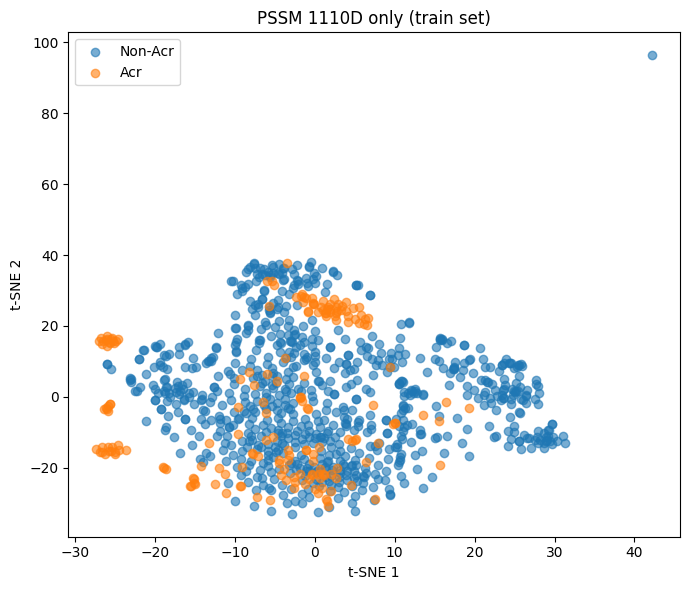

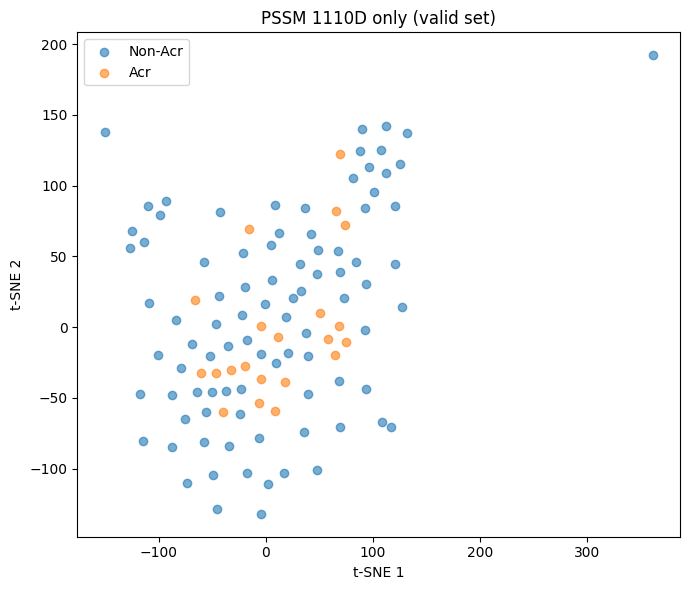

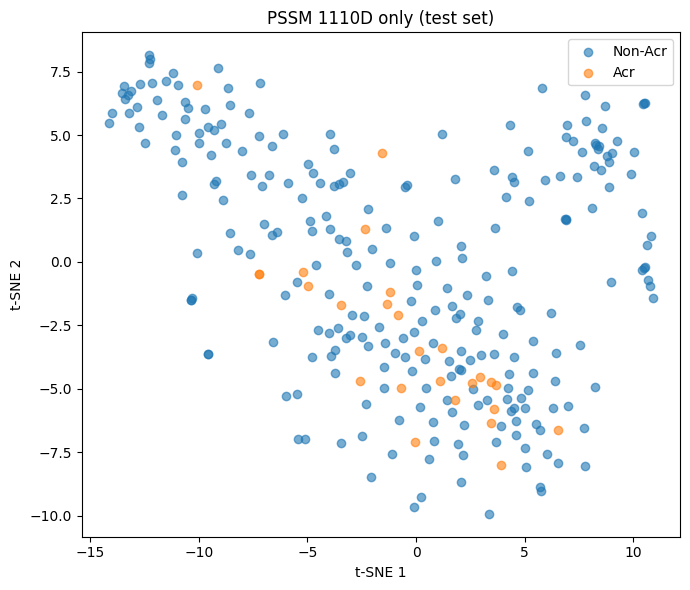

In [7]:
for split_name in ('train', 'valid', 'test'):
    X_s, y_s = splits[split_name]
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, max(5, len(X_s)//4)))
    emb_2d = tsne.fit_transform(X_s)
    fig, ax = plt.subplots(figsize=(7, 6))
    for l, name in [(0, 'Non-Acr'), (1, 'Acr')]:
        mask = y_s == l
        ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], alpha=0.6, label=name)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend()
    ax.set_title(f'PSSM {PSSM_DIM}D only ({split_name} set)')
    plt.tight_layout()
    plt.show()